## 时间序列预测任务

- 数据集：气温数据，多种指标
- 任务目标：预测未来某一时间点的气温/未来某一时间片段的气温


In [1]:
import warnings
warnings.filterwarnings("ignore")
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2024-08-04 16:32:47.700785: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-04 16:32:47.718617: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-04 16:32:47.724028: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-04 16:32:47.737408: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-04 16:32:48.525039: W tensorflow/compiler/tf2

In [2]:
df = pd.read_csv('jena_climate_2009_2016.csv')
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


每10分钟会记录一次，有多个指标

### 构建序列数据

- dataset表示输入的数据集，里面可以是一个或者多个列特征
- history_size表示时间窗口的大小：
- indices = range(i-history_size, i)表示窗口序列索引，i表示每个窗口的起始位置，即（0,0+history_size）（1，1+history_size）。。。
- target_size表示要预测的结果是窗口后的第几个时间点，0则表示下一时间点的预测结果，取其当做标签

In [3]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

前30W个样本数据当做训练的，剩余的当做验证集

In [4]:
TRAIN_SPLIT = 300000

In [5]:
tf.random.set_seed(13)

### 单特征训练模型

In [6]:
#只选一个温度特征
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

展示当前特征

array([<Axes: xlabel='Date Time'>], dtype=object)

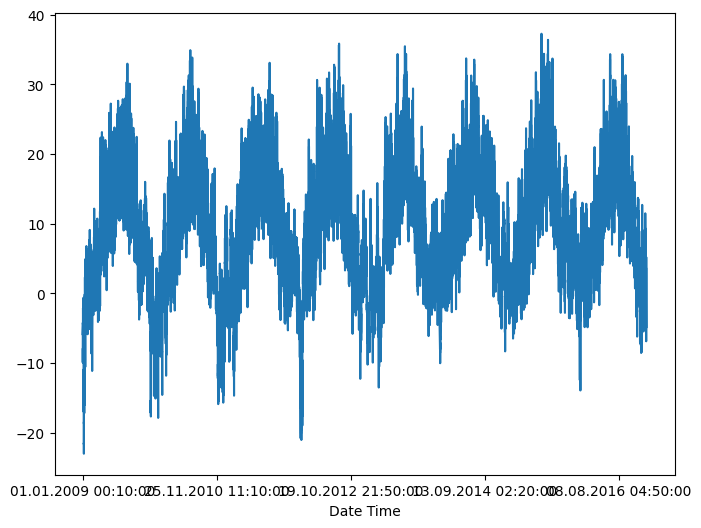

In [7]:
uni_data.plot(subplots=True)

In [8]:
uni_data = uni_data.values

### 数据预处理：标准化操作

In [9]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [10]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

窗口大小为20条数据，预测一个时刻的气温

In [11]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target) #用前300000个数据进行training数据的构建
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target) #利用uni_data中前300000个数据之后的数据进行testing数据的构建

数据与标签维度

In [12]:
x_train_uni.shape

(299980, 20, 1)

In [13]:
y_train_uni.shape

(299980,)

In [14]:
x_val_uni.shape

(120531, 20, 1)

In [15]:
y_val_uni.shape

(120531,)

训练特征X与标签Y

In [16]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


### 时间序列样本展示

In [17]:
def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

In [18]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from '/home/sjfx010/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

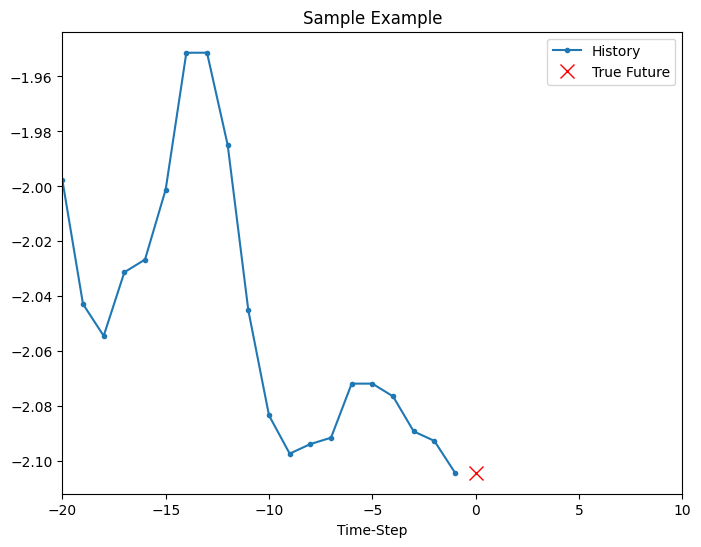

In [19]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### 最差也得比平均强吧

In [20]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/home/sjfx010/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

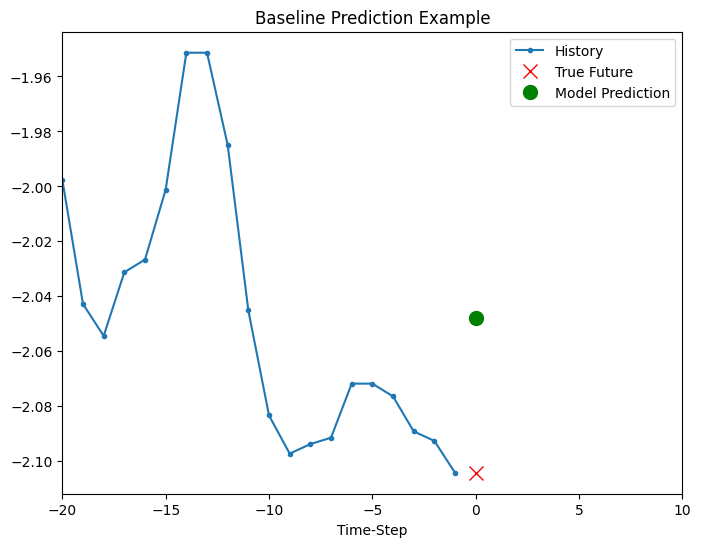

In [21]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,'Baseline Prediction Example')

### 构建RNN模型进行预测

In [22]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni)) #from_tensor_slices张量切片读取数据
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat() #shuffle打乱数据 batch形成batch
#cache将会储存数据，有利于后面的迭代中提高速度

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

2024-08-04 16:32:53.584668: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21552 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:23:00.0, compute capability: 7.5
2024-08-04 16:32:53.585354: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22984 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:83:00.0, compute capability: 7.5
2024-08-04 16:32:53.585868: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 12000 MB memory:  -> device: 2, name: Quadro RTX 6000, pci bus id: 0000:c3:00.0, compute capability: 7.5


In [23]:
train_univariate

<_RepeatDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [24]:
x_train_uni.shape[-2:]

(20, 1)

LSTM模型

In [25]:
simple_lstm_model = tf.keras.models.Sequential([   #keras.models.Sequential函数按照[]中的各层顺序构建模型
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]), #添加一个 LSTM 层，该层具有 8 个单元（或神经元)
    tf.keras.layers.Dense(1)  #全连接层，输出1个神经元
])

simple_lstm_model.compile(optimizer='adam', loss='mae')  #compile = 编译

得到一个batch的测试结果

In [26]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
(256, 1)


2024-08-04 16:32:55.254911: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
2024-08-04 16:32:55.291825: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


为了训练的能快点，一个epoch就训练200次

In [27]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL, #每个epoch中循环多少(EVALUATION_INTERVAL)次
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3282 - val_loss: 0.0678
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0790 - val_loss: 0.0246
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0362 - val_loss: 0.0332
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0392 - val_loss: 0.0427
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0212 - val_loss: 0.0215
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0234 - val_loss: 0.0198
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0260 - val_loss: 0.0209
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0238 - val_loss: 0.0280
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0221 - val_loss: 0.0189
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0213 - val_loss: 0.0170


### 用训练好的模型预测结果

展示其中部分数据的预测结果

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


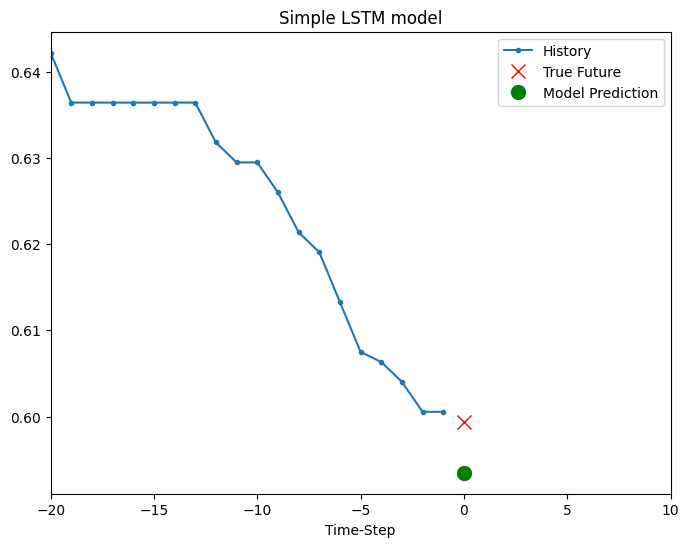

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


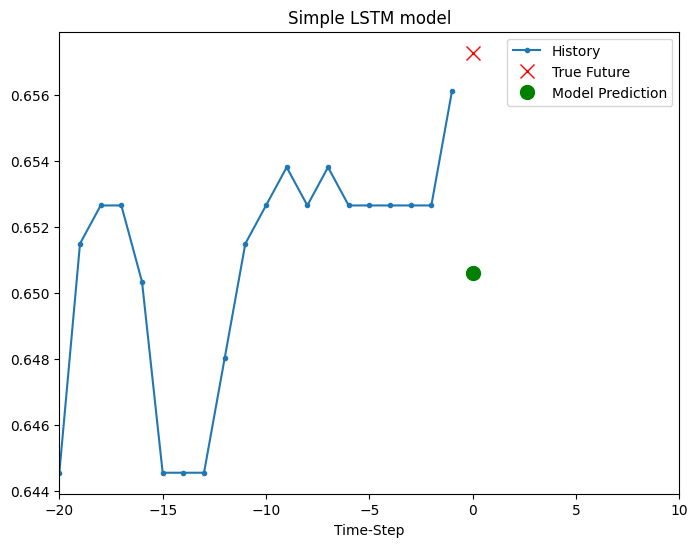

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


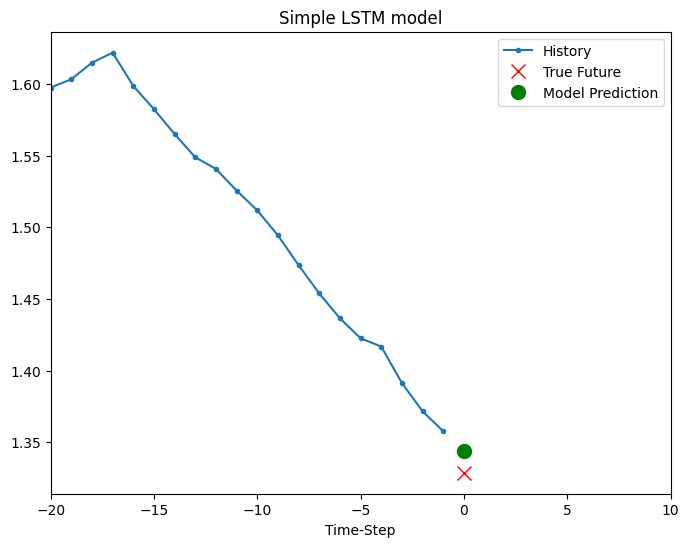

2024-08-04 16:33:07.462646: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [28]:
for x, y in val_univariate.take(3):  #take(3)  取了3个样本
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

有的还凑合，有的差的比较多

### 多用些特征看看效果

In [29]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [30]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


Let's have a look at how each of these features vary across time.

array([<Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>], dtype=object)

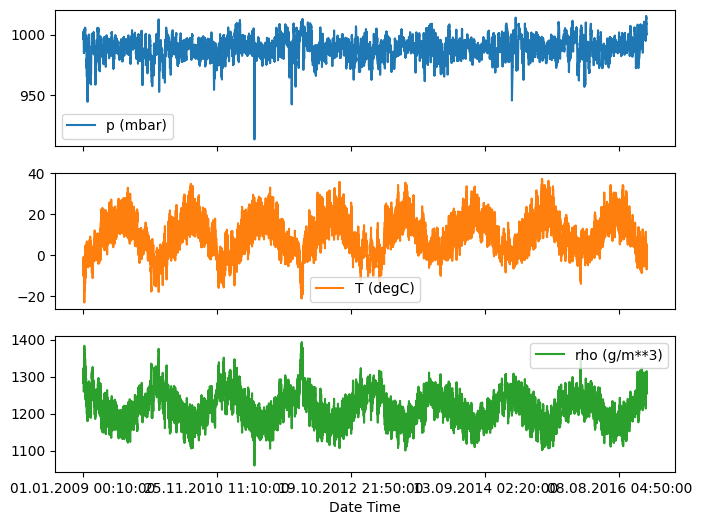

In [31]:
features.plot(subplots=True)

标准化的时候只能用训练数据

In [32]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [33]:
dataset = (dataset-data_mean)/data_std

### 时间窗口数据制作
- 只预测接下来一个时间点的结果

In [34]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step) #索引为range(0, 720, 6)，range(1, 721, 6) range(2, 722, 6) #step步长6，使取到的数据为每一小时一次
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size]) #（720+72）（721+72）  72=6*12 是一个时间点labels
        else:
            labels.append(target[i:i+target_size]) #一个时间段labels

    return np.array(data), np.array(labels)

- 选择训练窗口为5天的数据，5  * 24 乘 6=720条记录   -----5天，24小时，每小时有6个10分钟 --在数据文件中，数据就是每10分钟记录一次
- step=6表示每6隔6个时间点实际取一次数据，即窗口大小：720/6=120 ，索引为range(0, 720, 6)，range(0, 720, 6)
- 要预测的结果（标签）为12小时后的温度值，即12*6=72,72个时间点后的结果

In [35]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

数据维度

In [36]:
x_train_single.shape

(299280, 120, 3)

In [37]:
y_train_single.shape

(299280,)

### 构建训练数据

In [38]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [39]:
train_data_single

<_RepeatDataset element_spec=(TensorSpec(shape=(None, 120, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [40]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [41]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
(256, 1)


In [42]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.3745 - val_loss: 0.2569
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2701 - val_loss: 0.2654
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2644 - val_loss: 0.3387
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2586 - val_loss: 0.2621
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2200 - val_loss: 0.2657
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2436 - val_loss: 0.2833
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2432 - val_loss: 0.2358
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2401 - val_loss: 0.2839
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2470 - val_loss: 0.2266
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2518 - val_loss: 0.2520


### 训练结果展示

In [43]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

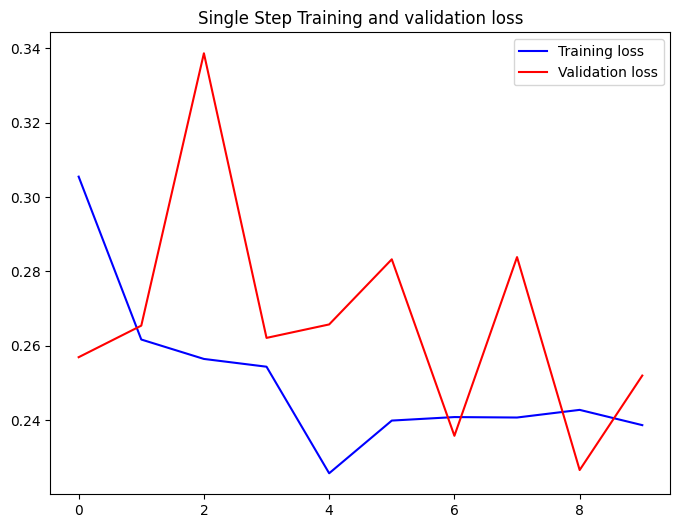

In [44]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


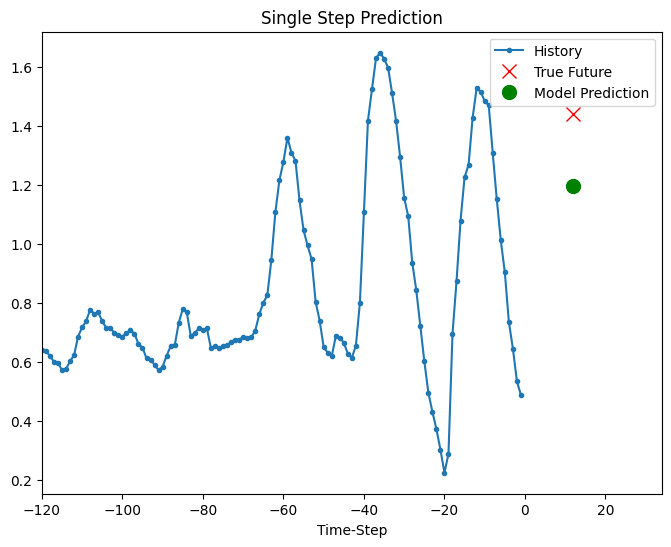

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


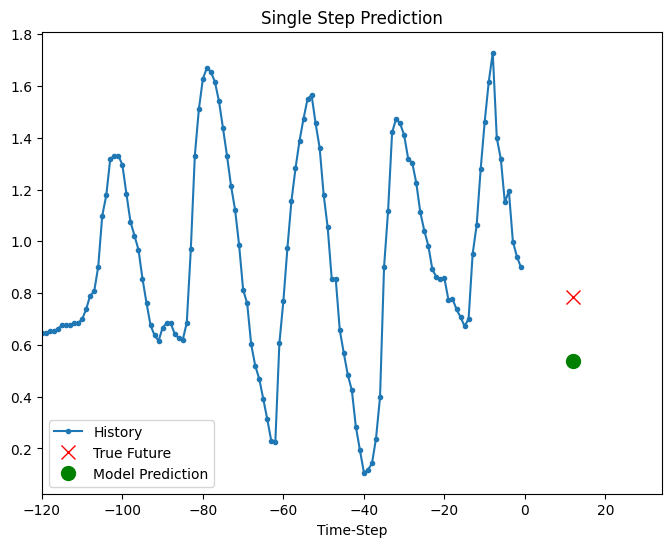

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


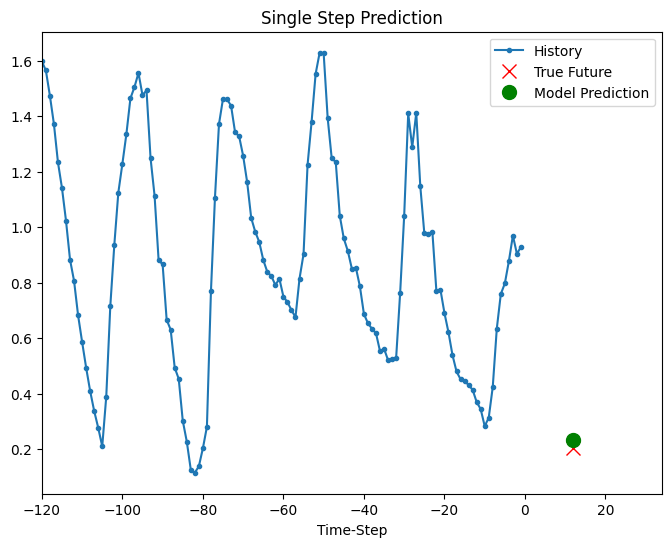

2024-08-04 16:33:35.397167: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [45]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
    plot.show()

### 预测接下来一个时间片段的结果

In [46]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [47]:
x_train_multi.shape

(299280, 120, 3)

In [48]:
y_train_multi.shape

(299280, 72)

In [49]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

要预测的序列

In [50]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

2024-08-04 16:33:43.810068: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


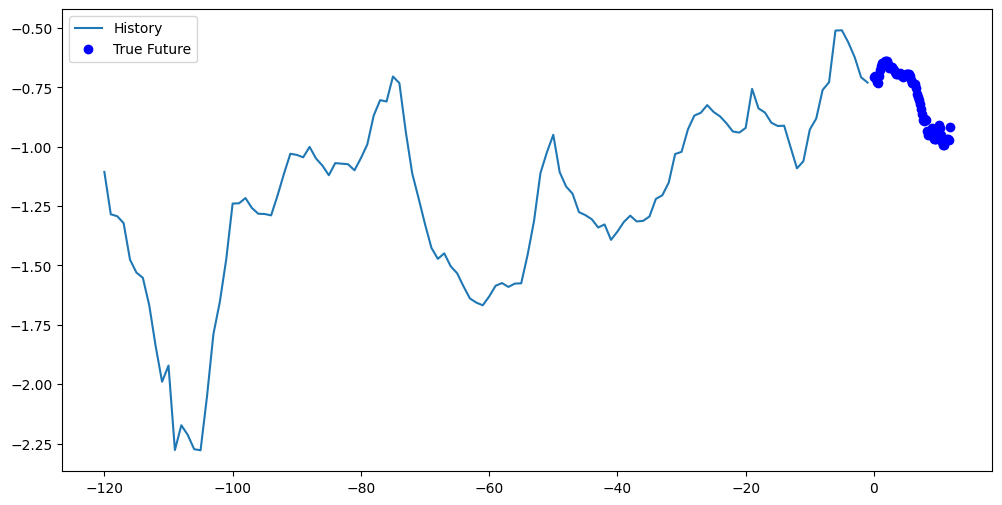

In [51]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

2层的LSTM网络，预测72个时间结果

In [52]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,  #此处要注意，此处意味这将32个神经元传给下一层
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

每个序列输入后都会得到72个预测结果

In [53]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step
(256, 72)


In [54]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 34s 157ms/step - loss: 0.7394 - val_loss: 0.2969
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 32s 162ms/step - loss: 0.3172 - val_loss: 0.2607
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 32s 157ms/step - loss: 0.2926 - val_loss: 0.3071
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 30s 149ms/step - loss: 0.2446 - val_loss: 0.2467
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 32s 162ms/step - loss: 0.1988 - val_loss: 0.2219
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 29s 147ms/step - loss: 0.2096 - val_loss: 0.2213
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 28s 142ms/step - loss: 0.2057 - val_loss: 0.1873
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 26s 131ms/step - loss: 0.2006 - val_loss: 0.2152
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 26s 129ms/step - loss: 0.2067 - val_loss: 0.1800
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 24s 122ms/step - loss: 0.2011 - val_loss: 0.2055


### 预测结果展示

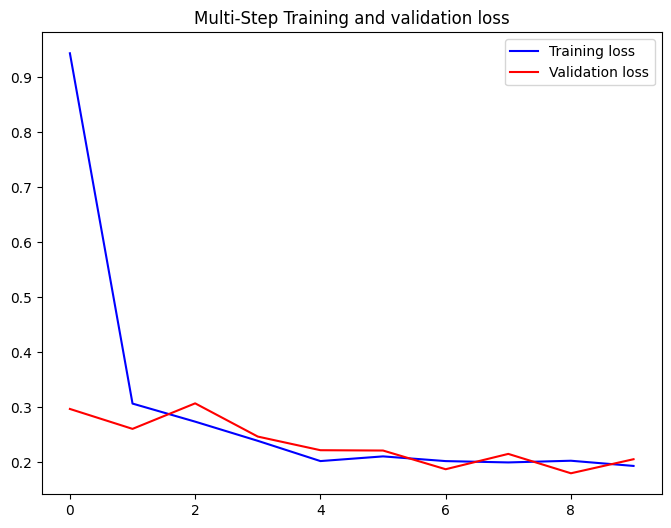

In [55]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


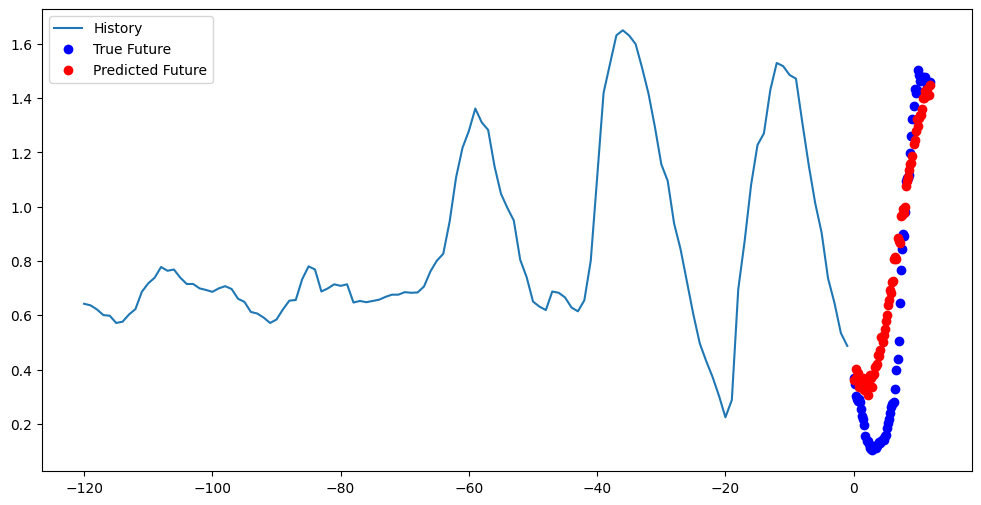

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


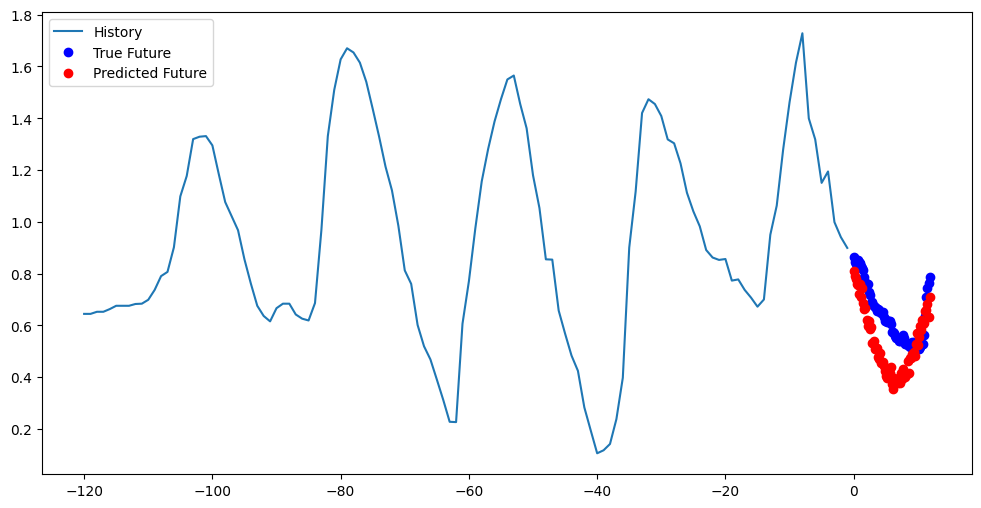

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


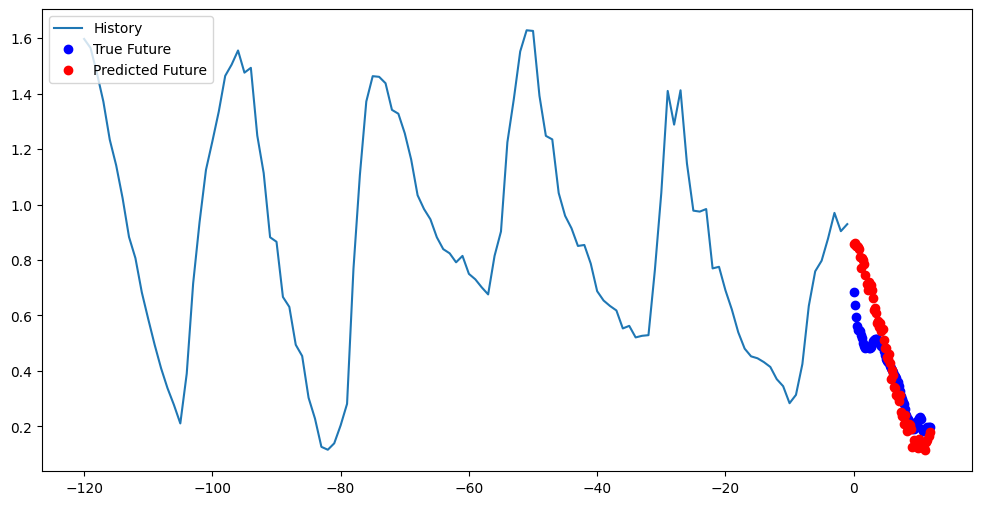

In [56]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])